# Data 144: Netflix Recommendations
By: Nikhita Anumukonda, Ishika Goel, Shirley Jiang, Payton McSweeney, Ameek Singh, and Jacy Zeng

[Presentation link](https://docs.google.com/presentation/d/1dr56WXtrms7wV4uNlfpGPSWJqlN46hRWY_n2MP-SgUU/edit#slide=id.g4dfce81f19_0_45)

## Introduction

In [ ]:
import pandas as pd
import re
from sklearn.preprocessing import MultiLabelBinarizer

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

### The Dataset

[Netflix Movies and TV Shows - Kaggle](https://www.kaggle.com/shivamb/netflix-shows)

### Objective

Currently, Netflix's movie search only finds movies by titles. For example, a search for "happy" brings shows with only "happy" in their titles. We want to build a movie recommendation system, taking into consideration of what as user wants in a movie based on emotions.

## Data Preprocessing
Original Dataset's Variables and Description ([Metadata from ygterl](https://github.com/ygterl/EDA-Netflix-2020-in-R/blob/master/Output-%20Exploration%20of%20Netflix%20Dataset%20in%20R.pdf))

`show_id` - unique ID for every movie/TV show

`type` - identifies if entry is a Movie or TV Show

`title` - name of the movie or TV show

`director` - director of the movie or TV show

`cast` -  actors involved in the movie or TV show

`country` - country where the movie or TV show was produce

`date_added` - the date when the movie or TV show was added to Netflix

`release_year` - the actual year the movie or TV show was released

`rating` - rating of the movie or TV show

`duration` - total duration of the movie in minutes or number of seasons in the TV show

`listed_in` - genre of the movie or TV show

`description` - summary description of the movie or TV show

We will be looking only at movie data for this project.

Problem statement: takes into account what you want in a movie (the description) and not just the name and how you feel and returns a set of movies that they recommend.


In [ ]:
url = 'https://raw.githubusercontent.com/ygterl/EDA-Netflix-2020-in-R/master/netflix_titles.csv'
df = pd.read_csv(url, index_col=0)
df.head(200)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,,
81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...,...,...,...,...,...,...
80136452,TV Show,Timeless Season,NaN,"Loo Aye Keng, Chen Ke Mei, Hady, Hishiko Woo, ...",NaN,"September 18, 2017",2009,TV-14,1 Season,"International TV Shows, TV Dramas","A decade after college, a wake reunites five f..."
80066798,Movie,Keith Richards: Under the Influence,Morgan Neville,Keith Richards,United States,"September 18, 2015",2015,TV-PG,82 min,"Documentaries, Music & Musicals","In a documentary with unparalleled access, dis..."
81147293,Movie,A Haunting at Silver Falls: The Return,Teo Konuralp,"Laura Flannery, James Cavlo, Harry Hains, Clem...",United States,"September 17, 2019",2019,TV-14,80 min,"Horror Movies, Independent Movies",When the ghost of her serial killer aunt seemi...


In [ ]:
movies = df[df['type'] == 'Movie']

movies.head()
movies["rating"].unique()
# clean so 'TV-Y7' = 'TV-Y7-FV', ranking based off the age, # 'NR' = 'UR' = nan
# in certain ranking

# 'TV-Y'->('TV-Y7'='TV-Y7-FV' )->'TV-G'->'TV-PG'->'PG-13'->'TV-14'->'R'->'TV-MA'-> ('NR' = 'UR' = nan)
# 1-9
cleanedmovies= movies
rankconvertions = {'TV-Y': 1,
                 'TV-Y7': 2, 'TV-Y7-FV': 2,
                 'TV-G': 3,
                 'TV-PG': 4,
                 'PG-13': 4,
                 'TV-14': 5,
                 'R': 6,
                 'TV-MA': 7, 
                 'NR': 8, 'UR': 8} #make nan = 8
def rankings(row):
  if row["rating"] in rankconvertions:
    return rankconvertions.get(row["rating"])
cleanedmovies["rating"]= cleanedmovies.apply(rankings, axis = 1)

In [ ]:
# cleaned duration=take out the minutes part of the duration
cleanedmovies['duration_minutes'] = cleanedmovies['duration'].str.split().apply(lambda x: x[0])
cleanedmovies.drop('duration', axis=1)
# cleaned date added to seperate them into month, year and date

months = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 
          'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 
          'November': 11, 'December': 12}
cleanedmovies['date_added'] = cleanedmovies['date_added'].fillna('January 0, 0000')
get_month = lambda x: months[x[0]]
get_date = lambda x: re.sub(r'[^\w\s]','', x[1])
get_yr = lambda x: x[2]
cleanedmovies['month_added'] = cleanedmovies['date_added'].str.split().apply(get_month)
cleanedmovies['day_added'] = cleanedmovies['date_added'].str.split().apply(get_date)
cleanedmovies['yr_added'] = cleanedmovies['date_added'].str.split().apply(get_yr)
cleanedmovies= cleanedmovies.drop(columns = ["date_added", "duration"])
cleanedmovies

,type,title,director,cast,country,release_year,rating,listed_in,description,duration_minutes,month_added,day_added,yr_added
show_id,,,,,,,,,,,,,
81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019,4.0,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,90,9,9,2019
80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016,7.0,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,94,9,9,2016
80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017,5.0,Comedies,When nerdy high schooler Dani finally attracts...,99,9,8,2017
70304989,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada",2014,6.0,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f...",110,9,8,2017
80164077,Movie,Fabrizio Copano: Solo pienso en mi,"Rodrigo Toro, Francisco Schultz",Fabrizio Copano,Chile,2017,7.0,Stand-Up Comedy,Fabrizio Copano takes audience participation t...,60,9,8,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80085438,Movie,Frank and Cindy,G.J. Echternkamp,NaN,United States,2007,7.0,Documentaries,Frank was a rising pop star when he married Ci...,70,4,1,2016
80085439,Movie,Frank and Cindy,G.J. Echternkamp,"Rene Russo, Oliver Platt, Johnny Simmons, Jane...",United States,2015,6.0,"Comedies, Dramas, Independent Movies",A student filmmaker vengefully turns his camer...,102,4,1,2016
80011846,Movie,Iverson,Zatella Beatty,Allen Iverson,United States,2014,8.0,"Documentaries, Sports Movies",This unfiltered documentary follows the rocky ...,88,4,1,2016


In [ ]:
# 1 hot encode countries, director, the cast 
# take out the minutes part of the duration
# separate the listed_in column and then 1 hot encode
# remove the show id column
# 1 hot encode countries, director, the cast 

cleanedmovies['director'] = cleanedmovies["director"].str.split(",")
cleanedmovies['director'] = cleanedmovies['director'].fillna("[]")
director = []
for x in cleanedmovies['director']:
  if x != '[]':
    x = [director + "_director" for director in x]
  else:
    x = '[]'
  director.append(x)
cleanedmovies['director'] = director

cleanedmovies["country"]= cleanedmovies["country"].fillna('[]')
cleanedmovies["cast"] = cleanedmovies["cast"].fillna('[]')
cleanedmovies["listed_in"]=cleanedmovies["listed_in"].fillna("[]")

cleanedmovies["country"]=cleanedmovies["country"].str.split(", ")
cleanedmovies["cast"] = cleanedmovies["cast"].str.split(", ")
cleanedmovies["listed_in"]=cleanedmovies["listed_in"].str.split(", ")

mlb = MultiLabelBinarizer(sparse_output=True)
listed_in = cleanedmovies.pop("listed_in")
cleanedmovies = cleanedmovies.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(listed_in),
                index=cleanedmovies.index,
                columns=mlb.classes_))

country = cleanedmovies.pop('country')
cleanedmovies = cleanedmovies.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(country),
                index=cleanedmovies.index,
                columns=mlb.classes_))

cleanedmovies= cleanedmovies.drop(columns=['[]']) #drop one-hot columns without a country
director = cleanedmovies.pop('director')
cleanedmovies = cleanedmovies.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(director),
                index=cleanedmovies.index,
                columns=mlb.classes_))

cast = cleanedmovies.pop('cast')
cleanedmovies = cleanedmovies.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(cast),
                index=cleanedmovies.index
                 ,columns=mlb.classes_))

In [ ]:
cleanedmovies.head()

,type,title,release_year,rating,description,duration_minutes,month_added,day_added,yr_added,Action & Adventure,Anime Features,Children & Family Movies,Classic Movies,Comedies,Cult Movies,Documentaries,Dramas,Faith & Spirituality,Horror Movies,Independent Movies,International Movies,LGBTQ Movies,Movies,Music & Musicals,Romantic Movies,Sci-Fi & Fantasy,Sports Movies,Stand-Up Comedy,Thrillers,Afghanistan,Albania,Argentina,Armenia,Australia,Austria,Bangladesh,Belgium,Bermuda,Botswana,Brazil,...,Óscar Torres,Ömer Duran,Öner Erkan,Öykü Çelik,Özge Borak,Özge Özberk,Özgü Namal,Özgür Emre Yıldırım,Özkan Uğur,Özlem Tekin,Özlem Türkad,Özlem Çakar,Úrsula Corberó,Úrsula Pruneda,Ülkü Duru,Ümit Bülent Dinçer,Þorsteinn Bachmann,Þröstur Leó Gunnarsson,Čestmír Řanda,İbrahim Büyükak,İbrahim Çelikkol,İclal Aydın,İdil Dizdar,İdil Fırat,İkra Külahlıoğlu,İlker Aksum,İlker Kaleli,İlknur Külahlıoglu,İpek Bilgin,İrem Sak,İştar Gökseven,"Łukasz ""Lotek” Lodkowski",Şafak Pekdemir,Şafak Sezer,Şebnem Bozoklu,Şenay Bozoklar,Şerif Sezer,Şinasi Yurtsever,Şükran Ovalı,Şükrü Özyıldız
show_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
81145628,Movie,Norm of the North: King Sized Adventure,2019,4.0,Before planning an awesome wedding for his gra...,90,9,9,2019,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
80117401,Movie,Jandino: Whatever it Takes,2016,7.0,Jandino Asporaat riffs on the challenges of ra...,94,9,9,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
80125979,Movie,#realityhigh,2017,5.0,When nerdy high schooler Dani finally attracts...,99,9,8,2017,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
70304989,Movie,Automata,2014,6.0,"In a dystopian future, an insurance adjuster f...",110,9,8,2017,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
80164077,Movie,Fabrizio Copano: Solo pienso en mi,2017,7.0,Fabrizio Copano takes audience participation t...,60,9,8,2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Data Visualization
Here we look at what movies are represented in our Netflix dataset.

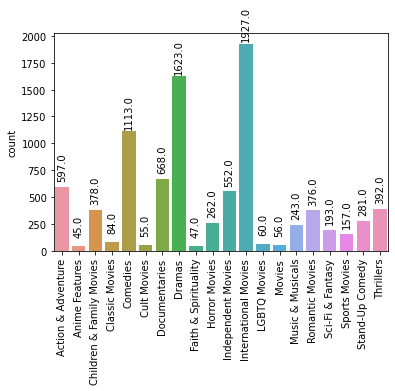

In [ ]:
# Genre counts
mlb.fit_transform(listed_in)
genres = mlb.classes_
counts = []
for genre in genres:
  counts.append(cleanedmovies[genre].sum())
s = sns.barplot(x=genres, y=counts)
s.set_xticklabels(labels=genres,rotation=90)
for p in s.patches:
    s.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 20), rotation=90,
                   textcoords = 'offset points')
plt.ylabel("count");

Here, the `movies` dataframe will be cleaned similarly to `cleanedmovies` except only relevant visualization columns will be kept (namely, duration, genre, country of production, duration, listed_in(aka genre))

In [ ]:
movie_viz= movies
movie_viz['duration_minutes'] = movie_viz['duration'].str.split().apply(lambda x: x[0])
movie_viz.drop('duration', axis=1)
movie_viz["country"]= movie_viz["country"].fillna('[]')
movie_viz["listed_in"]=movie_viz["listed_in"].fillna("[]")
movie_viz["country"]=movie_viz["country"].str.split(", ")
movie_viz["listed_in"]=movie_viz["listed_in"].str.split(", ")
movie_viz.head(3)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_minutes,month_added,day_added,yr_added
show_id,,,,,,,,,,,,,,,
81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","[United States, India, South Korea, China]","September 9, 2019",2019,4.0,90 min,"[Children & Family Movies, Comedies]",Before planning an awesome wedding for his gra...,90,9,9,2019
80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,[United Kingdom],"September 9, 2016",2016,7.0,94 min,[Stand-Up Comedy],Jandino Asporaat riffs on the challenges of ra...,94,9,9,2016
80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",[United States],"September 8, 2017",2017,5.0,99 min,[Comedies],When nerdy high schooler Dani finally attracts...,99,9,8,2017


In [ ]:
ctry = movie_viz['country'].apply(pd.Series).reset_index().melt(id_vars='show_id').dropna()[['show_id', 'value']].set_index('show_id')
gnre = movie_viz['listed_in'].apply(pd.Series).reset_index().melt(id_vars='show_id').dropna()[['show_id', 'value']].set_index('show_id')
# exploded list code reference: https://stackoverflow.com/questions/50217968/pandas-split-list-in-column-into-multiple-rows
movie_viz = pd.merge(pd.merge(ctry, gnre, left_index=True, right_index=True), 
                     movie_viz[['title', 'rating', 'duration_minutes']], 
                     left_index=True, right_index=True).rename(columns={'value_x': 'country', 'value_y': 'genre'})
movie_viz

,country,genre,title,rating,duration_minutes
show_id,,,,,
247747,India,Action & Adventure,Amar Akbar Anthony,5.0,172
247747,India,Classic Movies,Amar Akbar Anthony,5.0,172
247747,India,Comedies,Amar Akbar Anthony,5.0,172
269880,United States,Action & Adventure,Bad Boys,6.0,119
269880,United States,Comedies,Bad Boys,6.0,119
...,...,...,...,...,...
81228864,South Africa,Action & Adventure,Blitz Patrollie,7.0,102
81228864,South Africa,Comedies,Blitz Patrollie,7.0,102
81228864,South Africa,International Movies,Blitz Patrollie,7.0,102


In [ ]:
def label_bar(s, x=0, y=2):
  """Labels the top of bar chart with number"""
  for p in s.patches:
    s.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom', 
                   xytext = (x, y), rotation=90,
                   textcoords = 'offset pixels')

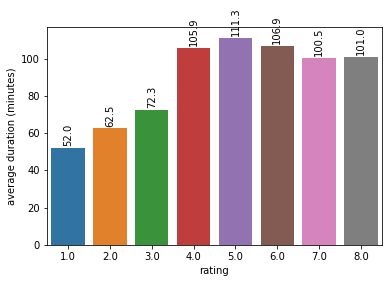

In [ ]:
movie_viz['duration_minutes'] = movie_viz['duration_minutes'].astype('int')
rate_duration = movie_viz.groupby('rating').mean().reset_index()
rate_duration['pair'] = rate_duration['rating'].astype(int).astype(str) + ", " +  rate_duration['duration_minutes'].round(1).astype(str)
# Duration vs Rating
s=sns.barplot(x=rate_duration['rating'], y=rate_duration['duration_minutes'])
label_bar(s)
plt.ylabel("average duration (minutes)");

In [ ]:
# The rating and its corresponding value
rankconvertions

{'NR': 8,
 'PG-13': 4,
 'R': 6,
 'TV-14': 5,
 'TV-G': 3,
 'TV-MA': 7,
 'TV-PG': 4,
 'TV-Y': 1,
 'TV-Y7': 2,
 'TV-Y7-FV': 2,
 'UR': 8}

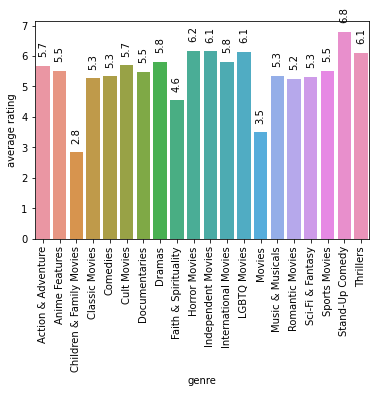

In [ ]:
# Genre vs Rating
# Bar plot annotation from: https://datavizpyr.com/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
genre_rate = movie_viz.groupby('genre').mean().reset_index()
s = sns.barplot(x=genre_rate['genre'], y=genre_rate['rating'])
s.set_xticklabels(labels=genre_rate['genre'],rotation=90)
label_bar(s, 0, 9)
plt.ylabel("average rating");

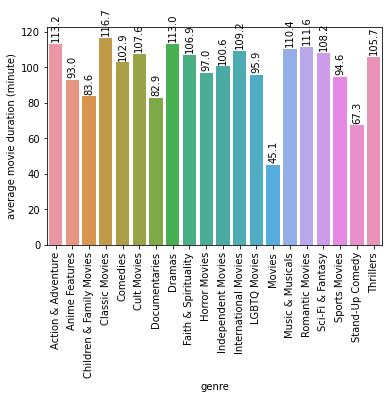

In [ ]:
# Duration vs. Genre
genre_rate = movie_viz.groupby('genre').mean().reset_index()
s = sns.barplot(x=genre_rate['genre'], y=genre_rate['duration_minutes'])
s.set_xticklabels(labels=genre_rate['genre'],rotation=90)
label_bar(s)
plt.ylabel("average movie duration (minute)");

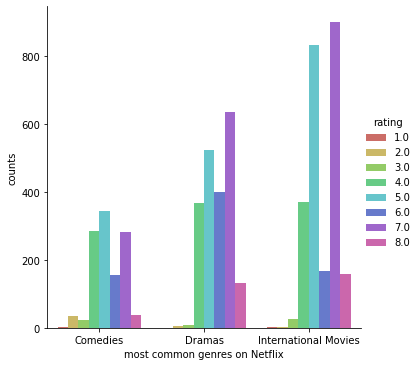

In [ ]:
# Genre (top 3) and Rating distribution
gen_rat = movie_viz.groupby(['genre', 'rating']).count().reset_index()
gen_ls = ['Comedies', 'Dramas', "International Movies"]
gen_rat_ls = gen_rat[gen_rat['genre'].isin(gen_ls)]
s = sns.catplot(x='genre', y='title', hue='rating', data=gen_rat_ls, kind='bar', palette=sns.color_palette("hls", 8))
plt.xlabel("most common genres on Netflix")
plt.ylabel("counts");

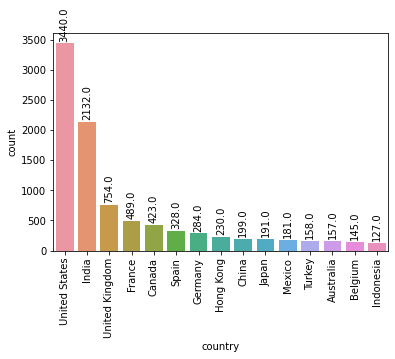

In [ ]:
# Movie counts of top 15 movie producing countries
countries = movie_viz[movie_viz['country'] != '[]']
c_count = countries.groupby('country').count().reset_index()
c_count = c_count.sort_values(by='title', ascending=False)[:15]
s = sns.barplot(x=c_count['country'], y=c_count['title'])
s.set_xticklabels(labels=c_count['country'],rotation=90)
label_bar(s)
plt.ylabel("count");

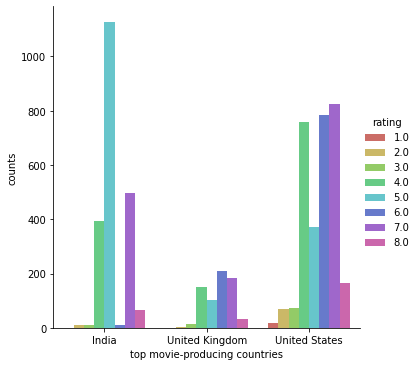

In [ ]:
# Rating distribution of films made by top 3 film producing countries
cd = countries.groupby(['country', 'rating']).count().reset_index()
ctry_lst = ['United States', 'India', "United Kingdom"]
cd_df = cd[cd['country'].isin(ctry_lst)]
s = sns.catplot(x='country', y='title', hue='rating', data=cd_df, kind='bar', palette=sns.color_palette("hls", 8))
plt.xlabel("top movie-producing countries")
plt.ylabel("counts");

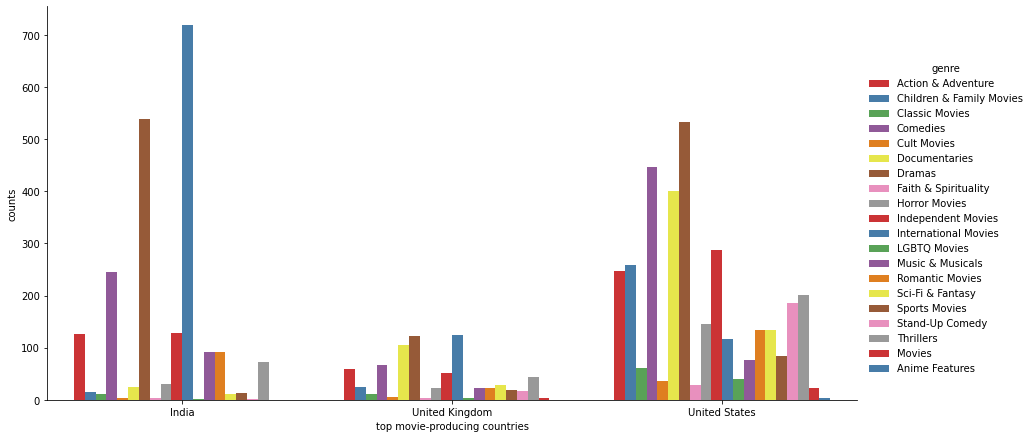

In [ ]:
# Country vs Genre -- Genre distribution by top 3 movie producing countries
cg = countries.groupby(['country', 'genre']).count().reset_index()
ctry_lst = ['United States', 'India', "United Kingdom"]
cg_df = cg[cg['country'].isin(ctry_lst)]
s = sns.catplot(x='country', y='title', hue='genre', data=cg_df, kind='bar', 
                palette=sns.color_palette("Set1", 20), height=6, aspect=2)
plt.xlabel("top movie-producing countries")
plt.ylabel("counts");

## Adding Features

To improve our model, we've taken other sources to add more information to our data. The following are some of the features we've added:
* Sentiment analysis of movie descriptions
* Sentiment analysis of movie scripts through joining script datasets (and why we couldn't accomplish it)
* Average character length of each word in the description
* Word2Vec T-SNE

List of Finalized Features for Dataset: 
> Title,
Release year,
Movie rating (encoded as ordinal values),
Movie duration,
Date added to Netflix (split by month, day, year),
Genre(s) (one-hot encoded),
Country of production (one-hot encoded),
Director (one-hot encoded),
Cast (one-hot encoded),
Sentiment of Description,
Average number of characters in each word of description,
Word2Vec of Description







### Sentiment analysis of movie descriptions
We will be using [NRC Word-Emotion Association Lexicon (aka EmoLex)](https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm) to analyze movie descriptions.


In [ ]:
nrc_url = 'https://raw.githubusercontent.com/s-jiang/data/main/NRC_eng_only.csv'
nrc = pd.read_csv(nrc_url)
nrc.head()

,word,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,aback,0,0,0,0,0,0,0,0,0,0
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,1,0,0,0,1,0,1,0,0
3,abandoned,0,1,1,0,0,1,0,1,0,0
4,abandonment,0,1,1,0,0,1,0,1,1,0


In order to correctly have NRC Lexicon words match up with the words in the movie description, the movie description must be cleaned. We will remove punctuation and make words lowercase.

In [ ]:
import string
pattern = r'''(?x) 
(?:[A-Z]\.)+       
|\w+(?:[-']\w+)*   
|\$?\d+(?:\.\d+)?
|\.\.\.
|[.,;"'?()-_`] 
'''
nopunct = []
for sent in cleanedmovies['description']:
  a = [w.lower() for w in sent.split() if w not in string.punctuation]
  nopunct.append(" ".join(a))
cleanedmovies['description'] = nopunct
cleanedmovies.head(3)

,type,title,release_year,rating,description,duration_minutes,month_added,day_added,yr_added,Action & Adventure,Anime Features,Children & Family Movies,Classic Movies,Comedies,Cult Movies,Documentaries,Dramas,Faith & Spirituality,Horror Movies,Independent Movies,International Movies,LGBTQ Movies,Movies,Music & Musicals,Romantic Movies,Sci-Fi & Fantasy,Sports Movies,Stand-Up Comedy,Thrillers,Afghanistan,Albania,Argentina,Armenia,Australia,Austria,Bangladesh,Belgium,Bermuda,Botswana,Brazil,...,Óscar Torres,Ömer Duran,Öner Erkan,Öykü Çelik,Özge Borak,Özge Özberk,Özgü Namal,Özgür Emre Yıldırım,Özkan Uğur,Özlem Tekin,Özlem Türkad,Özlem Çakar,Úrsula Corberó,Úrsula Pruneda,Ülkü Duru,Ümit Bülent Dinçer,Þorsteinn Bachmann,Þröstur Leó Gunnarsson,Čestmír Řanda,İbrahim Büyükak,İbrahim Çelikkol,İclal Aydın,İdil Dizdar,İdil Fırat,İkra Külahlıoğlu,İlker Aksum,İlker Kaleli,İlknur Külahlıoglu,İpek Bilgin,İrem Sak,İştar Gökseven,"Łukasz ""Lotek” Lodkowski",Şafak Pekdemir,Şafak Sezer,Şebnem Bozoklu,Şenay Bozoklar,Şerif Sezer,Şinasi Yurtsever,Şükran Ovalı,Şükrü Özyıldız
show_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
81145628,Movie,Norm of the North: King Sized Adventure,2019,4.0,before planning an awesome wedding for his gra...,90,9,9,2019,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
80117401,Movie,Jandino: Whatever it Takes,2016,7.0,jandino asporaat riffs on the challenges of ra...,94,9,9,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
80125979,Movie,#realityhigh,2017,5.0,when nerdy high schooler dani finally attracts...,99,9,8,2017,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We want to get the words in the movie description that show up in the NRC Lexicon

[Source code: Trump vs State of the Union addresses](https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/upshot-trump-emolex/notebooks/Trump%20vs%20State%20of%20the%20Union%20addresses.ipynb?authuser=1#scrollTo=aTQdxqJZBf_l)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(vocabulary=nrc['word'],
                      use_idf=False, 
                      norm='l1') # ELL - ONE
matrix = vec.fit_transform(cleanedmovies['description'])
vocab = vec.get_feature_names()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wordcount_df = wordcount_df.set_index(cleanedmovies.index)
wordcount_df.head(3)

,aback,abacus,abandon,abandoned,abandonment,abate,abatement,abba,abbot,abbreviate,abbreviation,abdomen,abdominal,abduction,aberrant,aberration,abeyance,abhor,abhorrent,abide,ability,abject,ablation,ablaze,abnormal,aboard,abode,abolish,abolition,abominable,abomination,aboriginal,abort,abortion,abortive,abound,abovementioned,abrasion,abroad,abrogate,...,yearly,yearn,yearning,years,yeast,yell,yellow,yellows,yelp,yeoman,yesterday,yesteryear,yew,yield,yielding,yogi,yoke,yolk,yon,yonder,young,younger,youth,zany,zap,zeal,zealot,zealous,zebra,zenith,zephyr,zeppelin,zest,zip,zodiac,zone,zoo,zoological,zoology,zoom
show_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
81145628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80117401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80125979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Below is an example of words with angry sentiment as a dataframe, then the angry sentiment words on their own, and finally the angry words sentiment proportion for each movie description.

In [ ]:
display(nrc[nrc['anger'] == 1].head(3))
print('---')
angry_words = nrc[nrc['anger'] == 1]['word']
display(angry_words.head(3))
print('---')
wordcount_df[nrc[nrc['anger'] == 1]['word']].sum(axis=1).head(3)

,word,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
3,abandoned,0,1,1,0,0,1,0,1,0,0
4,abandonment,0,1,1,0,0,1,0,1,1,0
17,abhor,0,1,1,0,1,1,0,0,0,0


---


3       abandoned
4     abandonment
17          abhor
Name: word, dtype: object

---


show_id
81145628    0.333333
80117401    0.000000
80125979    0.222222
dtype: float64

We want to find the proportion of each sentiment represented in the description. That way we can find the majority sentiment of the description and assign that sentiment to that movie.

In [ ]:
sentiments = nrc.columns[1:]  # positive', 'negative', 'anger', 'anticipation', 'disgust', 'fear',
                              #'joy', 'sadness', 'surprise', 'trust'
sent_df  = pd.DataFrame()                           
for sentiment in sentiments:
  sent_df[sentiment] = wordcount_df[nrc[nrc[sentiment] == 1]['word']].sum(axis=1)
sent_df.head(3)

,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
show_id,,,,,,,,,,
81145628,0.222222,0.222222,0.333333,0.111111,0.111111,0.222222,0.000000,0.111111,0.000000,0.222222
80117401,0.125000,0.000000,0.000000,0.250000,0.000000,0.125000,0.125000,0.000000,0.000000,0.250000
80125979,0.333333,0.222222,0.222222,0.222222,0.222222,0.111111,0.222222,0.111111,0.222222,0.222222


In [ ]:
majority_sent = []
sent_prop = sent_df[sentiments].to_numpy()
val_sent  = {0: 'positive', 1: 'negative', 2: 'anger', 
             3: 'anticipation', 4: 'disgust', 5: 'fear', 
             6: 'joy', 7: 'saddness', 8: 'surprise', 9: 'trust'}
biggerpic = {0: 'positive', 1: 'negative', 2: 'negative', 
             3: 'positive', 4: 'negative', 5: 'negative', 
             6: 'positive', 7: 'negative', 8: 'positive', 9: 'positive'}
overall_mag = []
for i in range(len(cleanedmovies)): 
  ith_sent_prop = sent_prop[i]
  maj_sent_idx = np.argmax(ith_sent_prop)
  majority_sent.append(val_sent[maj_sent_idx])
  overall_mag.append(biggerpic[maj_sent_idx])
majority_sent
cleanedmovies['overall sentiment'] = majority_sent
cleanedmovies.head(3)

,type,title,release_year,rating,description,duration_minutes,month_added,day_added,yr_added,Action & Adventure,Anime Features,Children & Family Movies,Classic Movies,Comedies,Cult Movies,Documentaries,Dramas,Faith & Spirituality,Horror Movies,Independent Movies,International Movies,LGBTQ Movies,Movies,Music & Musicals,Romantic Movies,Sci-Fi & Fantasy,Sports Movies,Stand-Up Comedy,Thrillers,Afghanistan,Albania,Argentina,Armenia,Australia,Austria,Bangladesh,Belgium,Bermuda,Botswana,Brazil,...,Ömer Duran,Öner Erkan,Öykü Çelik,Özge Borak,Özge Özberk,Özgü Namal,Özgür Emre Yıldırım,Özkan Uğur,Özlem Tekin,Özlem Türkad,Özlem Çakar,Úrsula Corberó,Úrsula Pruneda,Ülkü Duru,Ümit Bülent Dinçer,Þorsteinn Bachmann,Þröstur Leó Gunnarsson,Čestmír Řanda,İbrahim Büyükak,İbrahim Çelikkol,İclal Aydın,İdil Dizdar,İdil Fırat,İkra Külahlıoğlu,İlker Aksum,İlker Kaleli,İlknur Külahlıoglu,İpek Bilgin,İrem Sak,İştar Gökseven,"Łukasz ""Lotek” Lodkowski",Şafak Pekdemir,Şafak Sezer,Şebnem Bozoklu,Şenay Bozoklar,Şerif Sezer,Şinasi Yurtsever,Şükran Ovalı,Şükrü Özyıldız,overall sentiment
show_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
81145628,Movie,Norm of the North: King Sized Adventure,2019,4.0,before planning an awesome wedding for his gra...,90,9,9,2019,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,anger
80117401,Movie,Jandino: Whatever it Takes,2016,7.0,jandino asporaat riffs on the challenges of ra...,94,9,9,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,anticipation
80125979,Movie,#realityhigh,2017,5.0,when nerdy high schooler dani finally attracts...,99,9,8,2017,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive


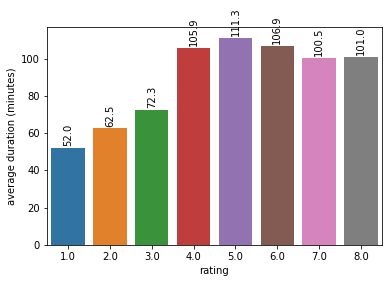

In [ ]:
movie_viz['duration_minutes'] = movie_viz['duration_minutes'].astype('int')
rate_duration = movie_viz.groupby('rating').mean().reset_index()
rate_duration['pair'] = rate_duration['rating'].astype(int).astype(str) + ", " +  rate_duration['duration_minutes'].round(1).astype(str)
# Duration vs Rating
s=sns.barplot(x=rate_duration['rating'], y=rate_duration['duration_minutes'])
label_bar(s)
plt.ylabel("average duration (minutes)");

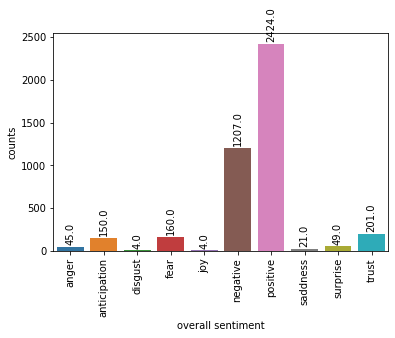

In [ ]:
descr_sent = cleanedmovies[['overall sentiment', 'title']].groupby('overall sentiment').count().reset_index()
s=sns.barplot(x=descr_sent['overall sentiment'], y=descr_sent['title'])
s.set_xticklabels(labels=descr_sent['overall sentiment'],rotation=90)
label_bar(s)
plt.ylabel("counts");

Once we get the sentiment strings, we will one-hot encode the sentiments.

In [ ]:
sents = pd.get_dummies(cleanedmovies['overall sentiment'], prefix='sentiment')
sents.head(2)

,sentiment_anger,sentiment_anticipation,sentiment_disgust,sentiment_fear,sentiment_joy,sentiment_negative,sentiment_positive,sentiment_saddness,sentiment_surprise,sentiment_trust
show_id,,,,,,,,,,
81145628,1,0,0,0,0,0,0,0,0,0
80117401,0,1,0,0,0,0,0,0,0,0


In [ ]:
cleanedmovies = pd.concat([cleanedmovies, pd.get_dummies(cleanedmovies['overall sentiment'], prefix='sentiment')], axis=1)
cleanedmovies.drop(['overall sentiment'], axis=1, inplace=True)
cleanedmovies.head(3)

,type,title,release_year,rating,description,duration_minutes,month_added,day_added,yr_added,Action & Adventure,Anime Features,Children & Family Movies,Classic Movies,Comedies,Cult Movies,Documentaries,Dramas,Faith & Spirituality,Horror Movies,Independent Movies,International Movies,LGBTQ Movies,Movies,Music & Musicals,Romantic Movies,Sci-Fi & Fantasy,Sports Movies,Stand-Up Comedy,Thrillers,Afghanistan,Albania,Argentina,Armenia,Australia,Austria,Bangladesh,Belgium,Bermuda,Botswana,Brazil,...,Özlem Türkad,Özlem Çakar,Úrsula Corberó,Úrsula Pruneda,Ülkü Duru,Ümit Bülent Dinçer,Þorsteinn Bachmann,Þröstur Leó Gunnarsson,Čestmír Řanda,İbrahim Büyükak,İbrahim Çelikkol,İclal Aydın,İdil Dizdar,İdil Fırat,İkra Külahlıoğlu,İlker Aksum,İlker Kaleli,İlknur Külahlıoglu,İpek Bilgin,İrem Sak,İştar Gökseven,"Łukasz ""Lotek” Lodkowski",Şafak Pekdemir,Şafak Sezer,Şebnem Bozoklu,Şenay Bozoklar,Şerif Sezer,Şinasi Yurtsever,Şükran Ovalı,Şükrü Özyıldız,sentiment_anger,sentiment_anticipation,sentiment_disgust,sentiment_fear,sentiment_joy,sentiment_negative,sentiment_positive,sentiment_saddness,sentiment_surprise,sentiment_trust
show_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
81145628,Movie,Norm of the North: King Sized Adventure,2019,4.0,before planning an awesome wedding for his gra...,90,9,9,2019,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
80117401,Movie,Jandino: Whatever it Takes,2016,7.0,jandino asporaat riffs on the challenges of ra...,94,9,9,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
80125979,Movie,#realityhigh,2017,5.0,when nerdy high schooler dani finally attracts...,99,9,8,2017,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Sentiment analysis of movie scripts through joining script datasets


**Question:** Can we extend our sentiment analysis to the full scripts of the movies in our `cleanedmovies` dataset? We compared a list of movie scripts avaliable on [IMSDB](https://www.imsdb.com/), the web's largest movie script resource to the list of movie titles we have in our dataset to empirically decide whether it is possible to look at scripts for sentiment analysis.

The `scriptsonIMSDB.csv` file was created by copy-pasting the list on the IMSDB website, removing the parenthetical text using regex, and using excel to remove director and excess newlines, leaving us with only movie titles.

The movies in `scriptsonIMSDB.csv` have a thing where titles that start with "The" are at the end of title rather than in the front. These 200+ movie titles were fixed manually by moving "The" and "A" to the front.


In [ ]:
# import movie title names and clean the movie title names
s = 'https://raw.githubusercontent.com/s-jiang/data/main/scriptsonIMSDB.csv'
imsdb_titles = pd.read_csv(s)
nopunct = []
for title in imsdb_titles['title']:
  a = [w.lower() for w in title.split() if w not in string.punctuation]
  nopunct.append(" ".join(a))
imsdb_titles['title'] = nopunct
imsdb_titles.head(3)

,title
0,10 things i hate about you
1,12
2,12 and holding


In [ ]:
# cleanedmovies title string cleaning
cm_titles = cleanedmovies.copy(deep=True)
cm_titles = cm_titles.reset_index()
nopunct = []
for title in cm_titles['title']:
  a = [w.lower() for w in title.split() if w not in string.punctuation]
  nopunct.append(" ".join(a))
cm_titles['title'] = nopunct
cm_titles.head(3)

,show_id,type,title,release_year,rating,description,duration_minutes,month_added,day_added,yr_added,Action & Adventure,Anime Features,Children & Family Movies,Classic Movies,Comedies,Cult Movies,Documentaries,Dramas,Faith & Spirituality,Horror Movies,Independent Movies,International Movies,LGBTQ Movies,Movies,Music & Musicals,Romantic Movies,Sci-Fi & Fantasy,Sports Movies,Stand-Up Comedy,Thrillers,Afghanistan,Albania,Argentina,Armenia,Australia,Austria,Bangladesh,Belgium,Bermuda,Botswana,...,Özlem Türkad,Özlem Çakar,Úrsula Corberó,Úrsula Pruneda,Ülkü Duru,Ümit Bülent Dinçer,Þorsteinn Bachmann,Þröstur Leó Gunnarsson,Čestmír Řanda,İbrahim Büyükak,İbrahim Çelikkol,İclal Aydın,İdil Dizdar,İdil Fırat,İkra Külahlıoğlu,İlker Aksum,İlker Kaleli,İlknur Külahlıoglu,İpek Bilgin,İrem Sak,İştar Gökseven,"Łukasz ""Lotek” Lodkowski",Şafak Pekdemir,Şafak Sezer,Şebnem Bozoklu,Şenay Bozoklar,Şerif Sezer,Şinasi Yurtsever,Şükran Ovalı,Şükrü Özyıldız,sentiment_anger,sentiment_anticipation,sentiment_disgust,sentiment_fear,sentiment_joy,sentiment_negative,sentiment_positive,sentiment_saddness,sentiment_surprise,sentiment_trust
0,81145628,Movie,norm of the north: king sized adventure,2019,4.0,before planning an awesome wedding for his gra...,90,9,9,2019,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,80117401,Movie,jandino: whatever it takes,2016,7.0,jandino asporaat riffs on the challenges of ra...,94,9,9,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,80125979,Movie,#realityhigh,2017,5.0,when nerdy high schooler dani finally attracts...,99,9,8,2017,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
# merge imsdb movie titles with matching titles in cleanedmovies (cm_titles)
imsdb_scripts = pd.merge(imsdb_titles, cm_titles, left_on='title', right_on='title', how='inner')
imsdb_scripts.head(3)

,title,show_id,type,release_year,rating,description,duration_minutes,month_added,day_added,yr_added,Action & Adventure,Anime Features,Children & Family Movies,Classic Movies,Comedies,Cult Movies,Documentaries,Dramas,Faith & Spirituality,Horror Movies,Independent Movies,International Movies,LGBTQ Movies,Movies,Music & Musicals,Romantic Movies,Sci-Fi & Fantasy,Sports Movies,Stand-Up Comedy,Thrillers,Afghanistan,Albania,Argentina,Armenia,Australia,Austria,Bangladesh,Belgium,Bermuda,Botswana,...,Özlem Türkad,Özlem Çakar,Úrsula Corberó,Úrsula Pruneda,Ülkü Duru,Ümit Bülent Dinçer,Þorsteinn Bachmann,Þröstur Leó Gunnarsson,Čestmír Řanda,İbrahim Büyükak,İbrahim Çelikkol,İclal Aydın,İdil Dizdar,İdil Fırat,İkra Külahlıoğlu,İlker Aksum,İlker Kaleli,İlknur Külahlıoglu,İpek Bilgin,İrem Sak,İştar Gökseven,"Łukasz ""Lotek” Lodkowski",Şafak Pekdemir,Şafak Sezer,Şebnem Bozoklu,Şenay Bozoklar,Şerif Sezer,Şinasi Yurtsever,Şükran Ovalı,Şükrü Özyıldız,sentiment_anger,sentiment_anticipation,sentiment_disgust,sentiment_fear,sentiment_joy,sentiment_negative,sentiment_positive,sentiment_saddness,sentiment_surprise,sentiment_trust
0,187,26597413,Movie,1997,6.0,after one of his high school students attacks ...,119,11,1,2019,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,9,70113538,Movie,2009,4.0,"in a postapocalyptic world, rag-doll robots hi...",80,11,16,2017,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,a most violent year,80017021,Movie,2014,6.0,abel morales tries to avoid corruption's easy ...,125,7,22,2018,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


We have 154 movie scripts avaliable from IMSDB. We were not able to get the scripts from IMSDB at this time due to out-of-date text scrapers and insufficient number of scripts.

---

We were also able to find a different database of movie scripts. Here we will get scripts from [Movie Scripts on Kaggle](https://www.kaggle.com/parthplc/movie-scripts).

In [ ]:
!git clone https://github.com/s-jiang/scripts.git

Cloning into 'scripts'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 1351 (delta 5), reused 18 (delta 3), pack-reused 1199
Receiving objects: 100% (1351/1351), 74.97 MiB | 19.20 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Checking out files: 100% (2827/2827), done.


The issue with this script dataset is that .txt files containing the movie scripts are unlabeled so we had to extract the titles of the films ourselves.

In [ ]:
import glob
filenames = glob.glob("/content/scripts/*")
scripts = [open(filename).read() for filename in filenames]
scripts_df = pd.DataFrame({
    'text': scripts,
    'filename': filenames
})
scripts_df.head(3)

,text,filename
0,TRU...,/content/scripts/file_1077.txt
1,"""Mission: Impossible 2"", shooting draft, by Ro...",/content/scripts/file_981.txt
2,Tomorrow Never Dies\n\n (BOND 18)\n\n ...,/content/scripts/file_1481.txt


The movie title extraction is performed through regex and exact match cleaning. In order to achieve the right regex call, a lot of exploration of the .txt files were necessary. For example, many scripts had html headings and, luckily, the html headings were consistent, so they were easily removed. Others were manually edited to have the movie title in the first line of the txt script file.

In [ ]:
scripts_df['text'] = scripts_df['text'].str.replace('^\s', '', regex=True)
scripts_df['text'] = scripts_df['text'].str.replace('<b>(.|\n)*?<\/b>', '', regex=True)
scripts_df['text'] = scripts_df['text'].str.replace('if (window!= top)\n\ntop.location.href=location.href\n\n\n\n', '', regex=False)
scripts_df['title'] = scripts_df['text'].apply(lambda value: value.split("\n")[0])
scripts_df['title'] = scripts_df['title'].str.replace('\s{2,}', '', regex=True)
scripts_df['title'] = scripts_df['title'].str.replace('"', '', regex=True)
scripts_df['title'] = scripts_df['title'].str.lower()
scripts_df = pd.DataFrame.drop_duplicates(scripts_df, subset=['title'])

nopunct = []
for title in scripts_df['title']:
  a = [w.lower() for w in title.split() if w not in string.punctuation]
  nopunct.append(" ".join(a))
scripts_df['title'] = nopunct
scripts_df.head()

,text,filename,title
0,TRUE...,/content/scripts/file_1077.txt,true grit
1,"""Mission: Impossible 2"", shooting draft, by Ro...",/content/scripts/file_981.txt,"mission: impossible 2, shooting draft, by robe..."
2,Tomorrow Never Dies\n\n (BOND 18)\n\n ...,/content/scripts/file_1481.txt,tomorrow never dies
3,"""NIGHTMARE 13: FREDDY MEETS JASON""\n\n\t\tNIGH...",/content/scripts/file_2168.txt,nightmare 13: freddy meets jason
4,JERRY MAGUIRE\n\n ...,/content/scripts/file_909.txt,jerry maguire


In [ ]:
cm_scripts = pd.merge(scripts_df, cm_titles, left_on='title', right_on='title', how='inner')
cm_scripts.head()

,text,filename,title,show_id,type,release_year,rating,description,duration_minutes,month_added,day_added,yr_added,Action & Adventure,Anime Features,Children & Family Movies,Classic Movies,Comedies,Cult Movies,Documentaries,Dramas,Faith & Spirituality,Horror Movies,Independent Movies,International Movies,LGBTQ Movies,Movies,Music & Musicals,Romantic Movies,Sci-Fi & Fantasy,Sports Movies,Stand-Up Comedy,Thrillers,Afghanistan,Albania,Argentina,Armenia,Australia,Austria,Bangladesh,Belgium,...,Özlem Türkad,Özlem Çakar,Úrsula Corberó,Úrsula Pruneda,Ülkü Duru,Ümit Bülent Dinçer,Þorsteinn Bachmann,Þröstur Leó Gunnarsson,Čestmír Řanda,İbrahim Büyükak,İbrahim Çelikkol,İclal Aydın,İdil Dizdar,İdil Fırat,İkra Külahlıoğlu,İlker Aksum,İlker Kaleli,İlknur Külahlıoglu,İpek Bilgin,İrem Sak,İştar Gökseven,"Łukasz ""Lotek” Lodkowski",Şafak Pekdemir,Şafak Sezer,Şebnem Bozoklu,Şenay Bozoklar,Şerif Sezer,Şinasi Yurtsever,Şükran Ovalı,Şükrü Özyıldız,sentiment_anger,sentiment_anticipation,sentiment_disgust,sentiment_fear,sentiment_joy,sentiment_negative,sentiment_positive,sentiment_saddness,sentiment_surprise,sentiment_trust
0,TRUE...,/content/scripts/file_1077.txt,true grit,1067876,Movie,1969,NaN,teenage tomboy mattie ross enlists the help of...,128,1,1,2020,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,Tomorrow Never Dies\n\n (BOND 18)\n\n ...,/content/scripts/file_1481.txt,tomorrow never dies,17016471,Movie,1997,4.0,"pierce brosnan stars in this 007 installment, ...",119,12,31,2019,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,"FINAL DESTINATION\n\n""FINAL DESTINATION"" \n\...",/content/scripts/file_1144.txt,final destination,60000393,Movie,2000,6.0,after narrowly avoiding a fatal plane explosio...,98,1,1,2020,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,AMERICAN PSYCHO\n\nby\n\nMary Harron and Guine...,/content/scripts/file_1648.txt,american psycho,60000861,Movie,2000,6.0,with chiseled good looks that belie his insani...,102,9,1,2019,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,MOON\n\n ...,/content/scripts/file_2706.txt,moon,70112500,Movie,2009,6.0,as he nears the end of a lonely three-year sti...,97,1,1,2020,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


There are overlaps between movie scripts from IMSDB and movie scripts from Kaggle. IMSDB has 154 matches and Kaggle has 133 matches. With that in mind, we have at least 154 unique movie scripts with our `cleanedmovies` dataset. We can complete sentiment analysis on these scripts along with other forms of analysis; however this is not enough data to use for our movie recommendation system.

### Other text analysis
https://textblob.readthedocs.io/en/dev/ 


In [ ]:
!pip install -U textblob
!python -m textblob.download_corpora

Requirement already up-to-date: textblob in /usr/local/lib/python3.6/dist-packages (0.15.3)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
def nlpfuncs(row):
  item = TextBlob(row)
  # polarity=np.mean([x.sentiment for x in item.sentences])
  polarity = item.sentiment.polarity
  subjectivity = item.sentiment.subjectivity
  return np.array([polarity, subjectivity])

result = cleanedmovies["description"].apply(nlpfuncs)
polarity = [item[0] for item in result]
subjectivity = [item[1] for item in result]
cleanedmovies["despolarity"]=polarity
cleanedmovies["dessubjectivity"]=subjectivity

In [ ]:
import os
import pprint
from urllib.request import urlopen

import gensim
from gensim import corpora, models, similarities
import nltk
from nltk import word_tokenize, tokenize
nltk.download('punkt')
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
url = 'https://raw.githubusercontent.com/ygterl/EDA-Netflix-2020-in-R/master/netflix_titles.csv'
df = pd.read_csv(url, index_col=0)
df.head(200)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
--2020-12-09 00:45:44--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.144.221
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.144.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  72.2MB/s    in 22s     

2020-12-09 00:46:06 (72.4 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,,
81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...,...,...,...,...,...,...
80136452,TV Show,Timeless Season,NaN,"Loo Aye Keng, Chen Ke Mei, Hady, Hishiko Woo, ...",NaN,"September 18, 2017",2009,TV-14,1 Season,"International TV Shows, TV Dramas","A decade after college, a wake reunites five f..."
80066798,Movie,Keith Richards: Under the Influence,Morgan Neville,Keith Richards,United States,"September 18, 2015",2015,TV-PG,82 min,"Documentaries, Music & Musicals","In a documentary with unparalleled access, dis..."
81147293,Movie,A Haunting at Silver Falls: The Return,Teo Konuralp,"Laura Flannery, James Cavlo, Harry Hains, Clem...",United States,"September 17, 2019",2019,TV-14,80 min,"Horror Movies, Independent Movies",When the ghost of her serial killer aunt seemi...


#### Average character length of each word in the description

In [ ]:
#Average character length of each word in description
movies = df[df['type'] == 'Movie']
description = movies['description']
tokenized_raw_array = []
for x in description:
  tokenized_raw = " ".join(nltk.regexp_tokenize(x, pattern))
  tokenized_raw_array.append(tokenize.sent_tokenize(tokenized_raw))
nopunct_arr = []
for x in tokenized_raw_array:
  nopunct = []
  for sent in x:
    a = [w for w in sent.split() if w not in string.punctuation]
    nopunct.append(" ".join(a))
  nopunct_arr.append(nopunct)
individual_words_array = []
for x in nopunct_arr:
  individual_words_array.append([nltk.word_tokenize(sent) for sent in x][0])
word_lengths_array = []
for i in individual_words_array:
  word_length_array = []
  for word in i:
    word_length_array.append(len(word))
  word_lengths_array.append(np.mean(word_length_array))

#### Word2Vec t-SNE


In [ ]:
#Word 2 Vec Output for each description
movies = df[df['type'] == 'Movie']
description = movies['description']
tokenized_raw_array = []
for x in description:
  tokenized_raw = " ".join(nltk.regexp_tokenize(x, pattern))
  tokenized_raw_array.append(tokenize.sent_tokenize(tokenized_raw))
nopunct_arr = []
for x in tokenized_raw_array:
  nopunct = []
  for sent in x:
    a = [w for w in sent.split() if w not in string.punctuation]
    nopunct.append(" ".join(a))
  nopunct_arr.append(nopunct)
individual_words_array = []
for x in nopunct_arr:
  individual_words_array.append([nltk.word_tokenize(sent) for sent in x][0])
for i in individual_words_array:
  for j in i:
    if(len(j) == 1):
      i.remove(j)
word2vecarray = []
description_word_vec_array = []
for i in individual_words_array:
  for word in i:
    try:
      word2vecarray.append(model[word][:20])
    except KeyError:
      continue
  sum = [0]*20
  for i in range(0, len(word2vecarray)):
    sum = word2vecarray[i] + sum
  sum = (sum/len(word2vecarray))
  description_word_vec_array.append(sum)
#do a dimensionanlity reduction, if certain words cluster, visualize the vectors, 
#each description, average along the words, not just the movie, and see if the words cluster together
#can take a movie vector minus certain words to get a certain movie. 
#Use the movie description as the corpus

#Use each description as a corpus, for each movie description get a vector, might take multiple
#vector for same corpus, then take the mean by word, use those vectors to get the mean for the movie
#then possibly use movie name minus some words to get a different movie, visualizations with cosine distance

In [ ]:
from sklearn.manifold import TSNE

data_embed=TSNE(n_components=2, perplexity=50, verbose=2, method='barnes_hut').fit_transform(description_word_vec_array)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4265 samples in 0.011s...
[t-SNE] Computed neighbors for 4265 samples in 0.405s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4265
[t-SNE] Computed conditional probabilities for sample 2000 / 4265
[t-SNE] Computed conditional probabilities for sample 3000 / 4265
[t-SNE] Computed conditional probabilities for sample 4000 / 4265
[t-SNE] Computed conditional probabilities for sample 4265 / 4265
[t-SNE] Mean sigma: 0.000209
[t-SNE] Computed conditional probabilities in 0.716s
[t-SNE] Iteration 50: error = 69.6964417, gradient norm = 0.0323270 (50 iterations in 1.946s)
[t-SNE] Iteration 100: error = 57.6484947, gradient norm = 0.0153169 (50 iterations in 1.345s)
[t-SNE] Iteration 150: error = 54.1171341, gradient norm = 0.0094738 (50 iterations in 1.263s)
[t-SNE] Iteration 200: error = 52.3732529, gradient norm = 0.0071190 (50 iterations in 1.255s)
[t-SNE] Iteration 250: error = 51.3063583, gradient norm = 0.005105

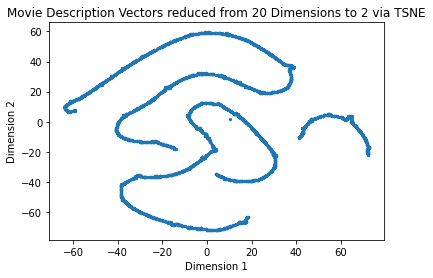

In [ ]:
## Vizualise
%matplotlib inline
from matplotlib import pyplot as plt

x_axis= data_embed[:,0]
y_axis=data_embed[:,1]

plt.scatter(x_axis, y_axis, s=5)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Movie Description Vectors reduced from 20 Dimensions to 2 via TSNE')
plt.show() ## The plots vary each time you run them 

In [ ]:
word2vec_df = pd.DataFrame(description_word_vec_array)
word2vec_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.081335,0.036218,-0.009187,0.039039,-0.019569,0.012626,0.047029,-0.112537,0.088885,0.048491,0.033191,-0.155971,-0.062975,0.047212,-0.100288,0.024016,0.042431,0.072915,-0.027658,-0.085579
1,0.086124,0.021474,-0.011765,0.069098,-0.041194,-0.025197,0.017317,-0.091385,0.068916,0.057738,-0.001416,-0.096187,-0.007808,0.069669,-0.093588,0.019777,0.025719,0.076487,-0.021613,-0.046566
2,0.084965,0.046965,-0.014575,0.050660,-0.050027,-0.028908,0.013948,-0.092310,0.051608,0.030296,0.001808,-0.099658,0.003761,0.060838,-0.088774,0.022534,0.019182,0.090626,0.008184,-0.029601
3,0.069723,0.035891,0.004175,0.033466,-0.042143,-0.025903,0.025906,-0.080542,0.050154,0.021877,-0.005580,-0.086223,-0.003645,0.036738,-0.089379,0.035605,0.009821,0.087463,-0.005145,-0.040710
4,0.058891,0.032869,0.001070,0.045331,-0.036347,-0.028046,0.019982,-0.080547,0.060131,0.021016,-0.006378,-0.076980,0.005793,0.036698,-0.096439,0.038327,0.013392,0.084804,-0.003484,-0.033902


In [ ]:
cleanedmovies['Dimension 1'] = x_axis
cleanedmovies['Dimension 2'] = y_axis
cleanedmovies.head()

,type,title,release_year,rating,description,duration_minutes,month_added,day_added,yr_added,Action & Adventure,Anime Features,Children & Family Movies,Classic Movies,Comedies,Cult Movies,Documentaries,Dramas,Faith & Spirituality,Horror Movies,Independent Movies,International Movies,LGBTQ Movies,Movies,Music & Musicals,Romantic Movies,Sci-Fi & Fantasy,Sports Movies,Stand-Up Comedy,Thrillers,Afghanistan,Albania,Argentina,Armenia,Australia,Austria,Bangladesh,Belgium,Bermuda,Botswana,Brazil,...,Ülkü Duru,Ümit Bülent Dinçer,Þorsteinn Bachmann,Þröstur Leó Gunnarsson,Čestmír Řanda,İbrahim Büyükak,İbrahim Çelikkol,İclal Aydın,İdil Dizdar,İdil Fırat,İkra Külahlıoğlu,İlker Aksum,İlker Kaleli,İlknur Külahlıoglu,İpek Bilgin,İrem Sak,İştar Gökseven,"Łukasz ""Lotek” Lodkowski",Şafak Pekdemir,Şafak Sezer,Şebnem Bozoklu,Şenay Bozoklar,Şerif Sezer,Şinasi Yurtsever,Şükran Ovalı,Şükrü Özyıldız,sentiment_anger,sentiment_anticipation,sentiment_disgust,sentiment_fear,sentiment_joy,sentiment_negative,sentiment_positive,sentiment_saddness,sentiment_surprise,sentiment_trust,despolarity,dessubjectivity,Dimension 1,Dimension 2
show_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
81145628,Movie,Norm of the North: King Sized Adventure,2019,4.0,before planning an awesome wedding for his gra...,90,9,9,2019,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.033333,0.516667,10.227191,1.829640
80117401,Movie,Jandino: Whatever it Takes,2016,7.0,jandino asporaat riffs on the challenges of ra...,94,9,9,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.000000,0.000000,-59.178234,6.843123
80125979,Movie,#realityhigh,2017,5.0,when nerdy high schooler dani finally attracts...,99,9,8,2017,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.048333,0.401667,-59.242405,7.094123
70304989,Movie,Automata,2014,6.0,"in a dystopian future, an insurance adjuster f...",110,9,8,2017,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.066667,0.041667,-59.183418,7.818777
80164077,Movie,Fabrizio Copano: Solo pienso en mi,2017,7.0,fabrizio copano takes audience participation t...,60,9,8,2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.250000,0.250000,-59.230728,7.789320


## Algorithm - K means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

max_sil_score = 0
cleanedvalues = cleanedmovies.fillna(0).iloc[:, [5] + list(range(7, len(cleanedmovies.columns)))].values
for k in range (2, 10, 2):
  kmeans = KMeans(n_clusters = k, random_state = 42)
  kmeans.fit(cleanedvalues)
  sil_score = silhouette_score(cleanedvalues, kmeans.labels_)
  if sil_score > max_sil_score:
    max_sil_score = sil_score
    bestk = k
  
bestk

4

In [ ]:
from scipy.spatial.distance import cdist
import numpy as np

elbow = []
distortions = []
cleanedvaluesdf = pd.DataFrame(cleanedvalues)
K = range(1, 8)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(cleanedvaluesdf)
    kmeanModel.fit(cleanedvaluesdf)
    elbow.append(kmeanModel.inertia_)
    # distortions.append(sum(np.min(cdist(cleanedvaluesdf, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / cleanedvaluesdf.shape[0])

# Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

# Best k: ~2


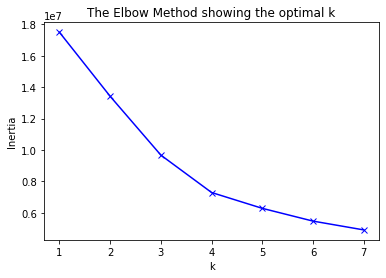

In [ ]:

import matplotlib
import matplotlib.pyplot as plt
plt.plot(K, elbow, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
cleanedmovies.iloc[:, list(range(5, len(cleanedmovies.columns)))]#['genre']

,duration_minutes,month_added,day_added,yr_added,Action & Adventure,Anime Features,Children & Family Movies,Classic Movies,Comedies,Cult Movies,Documentaries,Dramas,Faith & Spirituality,Horror Movies,Independent Movies,International Movies,LGBTQ Movies,Movies,Music & Musicals,Romantic Movies,Sci-Fi & Fantasy,Sports Movies,Stand-Up Comedy,Thrillers,Afghanistan,Albania,Argentina,Armenia,Australia,Austria,Bangladesh,Belgium,Bermuda,Botswana,Brazil,Bulgaria,Cambodia,Canada,Cayman Islands,Chile,...,Ülkü Duru,Ümit Bülent Dinçer,Þorsteinn Bachmann,Þröstur Leó Gunnarsson,Čestmír Řanda,İbrahim Büyükak,İbrahim Çelikkol,İclal Aydın,İdil Dizdar,İdil Fırat,İkra Külahlıoğlu,İlker Aksum,İlker Kaleli,İlknur Külahlıoglu,İpek Bilgin,İrem Sak,İştar Gökseven,"Łukasz ""Lotek” Lodkowski",Şafak Pekdemir,Şafak Sezer,Şebnem Bozoklu,Şenay Bozoklar,Şerif Sezer,Şinasi Yurtsever,Şükran Ovalı,Şükrü Özyıldız,sentiment_anger,sentiment_anticipation,sentiment_disgust,sentiment_fear,sentiment_joy,sentiment_negative,sentiment_positive,sentiment_saddness,sentiment_surprise,sentiment_trust,despolarity,dessubjectivity,Dimension 1,Dimension 2
show_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
81145628,90,9,9,2019,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.033333,0.516667,10.227191,1.829640
80117401,94,9,9,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.000000,0.000000,-59.178234,6.843123
80125979,99,9,8,2017,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.048333,0.401667,-59.242405,7.094123
70304989,110,9,8,2017,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.066667,0.041667,-59.183418,7.818777
80164077,60,9,8,2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.250000,0.250000,-59.230728,7.789320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80085438,70,4,1,2016,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.316667,0.150000,72.297028,-21.650095
80085439,102,4,1,2016,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.050000,0.250000,72.346588,-21.693668
80011846,88,4,1,2016,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000000,0.000000,72.374512,-21.782150


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

max_sil_score = 0
cleanedvalues = cleanedmovies.fillna(0).iloc[:, [5] + list(range(7, len(cleanedmovies.columns)))].values
for k in range (2, 20, 2):
  kmeans = KMeans(n_clusters = k, random_state = 42)
  kmeans.fit(cleanedvalues)
  sil_score = silhouette_score(cleanedvalues, kmeans.labels_)
  if sil_score > max_sil_score:
    max_sil_score = sil_score
    bestk = k
  
bestk

4

In [ ]:
tot_len = len(cleanedmovies.columns)
cleancopy = cleanedmovies
for dir in list(cleancopy.columns[138:tot_len - 12]):
  cleancopy[dir + " Director"] = cleancopy[dir]
  cleancopy.drop(dir, axis=1)




```
Function: Takes in input, emotion as strings
possible emotions: sentiment_anger, sentiment_anticipation,sentiment_disgust, sentiment_fear,sentiment_joy	sentiment_negative, sentiment_positive,sentiment_saddness	sentiment_surprise, sentiment_trust
Specification: specifically when inputting the director as an input, one needs to include "_director" at the end of the input
```



In [ ]:
cleanedmovies["biggerpicemotion"] =overall_mag
associations = {"sentiment_anger": "negative", 
                "sentiment_anticipation": "negative", 
                "sentiment_disgust": "negative", 
                "sentiment_fear": "negative", 
                "sentiment_fear": "negative", 
                "sentiment_saddness": "negative", 
                "sentiment_joy": "positive", 
                "sentiment_surprise": "positive", 
                "sentiment_trust": "positive", 
                }
def returningrec(input, emotion):
  if input in cleanedmovies.columns:
    # pick out the movies with said emotion
    cleanedvalues= cleanedmovies.loc[cleanedmovies[emotion] == 1]
    # filter the movies by the input (if doesn't exists try to broaden the emotion)
    if (len(cleanedvalues.loc[ cleanedvalues[input] == 1])!=0):
      newdf = cleanedvalues.loc[ cleanedvalues[input] == 1]
      newdf=newdf.drop("biggerpicemotion",1)
      if (len(newdf)<5):
        newdf = newdf
      else:
        kmeans = KMeans(n_clusters = 5, random_state = 42)
        kmeans.fit(newdf.fillna(0).iloc[:, [5] + list(range(7, len(newdf.columns)))].values)
        newdf["kmeans"] = kmeans.labels_
        newdf = newdf.sort_values(by=["kmeans"])
    # restart process with more broader emotion
    elif (len(cleanedmovies.loc[cleanedmovies["biggerpicemotion"] == associations[emotion]])!=0):
      newdf = cleanedmovies.loc[cleanedmovies["biggerpicemotion"] == associations[emotion]]
      # continue with the same process of filtering by input
      if (len(newdf.loc[newdf[input] == 1])!=0):
        newdf = newdf.loc[newdf[input] == 1]
        if (len(newdf)<5):
          newdf = newdf
        else:
          newdf=newdf.drop("biggerpicemotion",1)
          kmeans = KMeans(n_clusters = 5, random_state = 42)
          kmeans.fit(newdf.fillna(0).iloc[:, [5] + list(range(7, len(newdf.columns)))].values)
          newdf["kmeans"] = kmeans.labels_
          newdf = newdf.sort_values(by=["kmeans"])
      else:
         print("sorry! the input you have is not in our database yet! Please try another input!")
         return
    else:
      print("An Error has Occured")
      return
  else:
    print("sorry! the input you have is not in our database yet! Please try another input!")
    return
  results = newdf[["title", "description"]]
  return results


In [ ]:
returningrec("Horror Movies","sentiment_anger")

,title,description
show_id,,
81168340,Medium,"in 1930s poland, a powerful psychic steers a g..."
81034612,Secrets in the Hot Spring,when three teen outcasts arrive at a hot sprin...


In [ ]:
returningrec("Dramas","sentiment_anger")

,title,description
show_id,,
80223195,Issaq,two young lovers in banaras are caught in the ...
80106947,Laal Rang,"eager for cash, rajesh joins his friend shanka..."
80244078,The Silence,"on a train in mumbai, 20-something chini witne..."
80085300,You Carry Me,"a soap opera producer, director and makeup art..."
70299748,Jersey Boys,"adapted from the hit broadway musical, this no..."
80148070,Blessed Benefit,"after being wrongfully convicted of fraud, an ..."
81168345,"Escape from the ""Liberty"" Cinema",artistic rebellion ignites at the movies when ...
80084767,Saadey CM Saab,three old friends who have always hated politi...
81035109,Mala Kahich Problem Nahi,"with their relationship running on autopilot, ..."


In [ ]:
returningrec("China","sentiment_joy")

,title,description
show_id,,
80988892,Next Gen,when lonely mai forms an unlikely bond with a ...
70270775,The Grandmaster,"as the japanese invasion looms, chinese kung f..."
80143797,I Am Not Madame Bovary,to qualify for an apartment reserved for singl...
81161230,Shanghai Fortress,a young man falls for a heroic general and soo...
80177834,The Guardian Brothers,when a chinese family's soup shop is targeted ...
80224362,Kings,a foster mom and her houseful of kids befriend...
70020728,Kung Fu Hustle,"sing, a mobster in 1940s china, longs to be as..."
60002907,"Crouching Tiger, Hidden Dragon",a young woman in ancient china longs for an ad...
80996790,Dr. Seuss' The Grinch,a grump with a mean streak plots to bring chri...


In [ ]:
returningrec("LGBTQ Movies","sentiment_joy")

,title,description
show_id,,
81122669,Daddy Issues,maya finally hooks up with her online dream gi...
81002594,Yes or No,traditional girl pie is initially uncomfortabl...
80186731,Gender Revolution: A Journey with Katie Couric,katie couric explores our evolving understandi...
80208091,Anchor and Hope,kat and eva’s happy romance hits a rough patch...
81024494,Postcards from London,after being recruited to be a raconteur in lon...
80201497,Princess Cyd,a teenager moves to chicago for the summer and...
81034763,Lez Bomb,a young woman's attempt to come out of the clo...
80117742,Hurricane Bianca,"fired for being gay, schoolteacher richard ret..."
80195885,The Pass,the lives and careers of two professional socc...
